In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [2]:
def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [36]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    task_input = np.zeros((2, n_trials))
    rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
    rOutput_trials = np.zeros((n_trials, TRIAL_TIME, N_OUTPUT_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            rMD = np.array(data["network_rates"]["r_MD"])
            rMD_trials[idx,:,:] = rMD
            rOutput = np.array(data["network_rates"]["r_output"])
            rOutput_trials[idx,:,:] = rOutput
            
    return (task_input, rMD_trials, rOutput_trials)

In [37]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]

# for i in range(len(RUNS_MD)):
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")

data = get_data("/om2/group/halassa/PFCMD-ali-sabrina/seed0_MDon/by_trial")

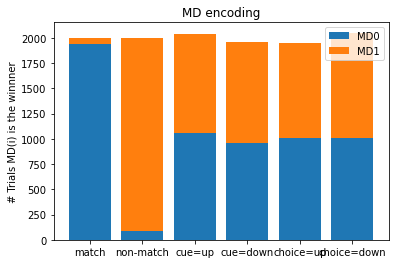

In [68]:
# For each trial determine: (1) winning MD neuron, (2) context, (3) cue, (4) output
N_TRIALS_IN_BLOCK = 500
TRIAL_TIME = 200

(task_input, rMD_trials, rOutput_trials) = data

starts_with_90 = True

n_match_MD0 = 0
n_nmatch_MD0 = 0
n_match_MD1 = 0
n_nmatch_MD1 = 0

n_cueup_MD0 = 0
n_cuedown_MD0 = 0
n_cueup_MD1 = 0
n_cuedown_MD1 = 0

n_choiceup_MD0 = 0
n_choicedown_MD0 = 0
n_choiceup_MD1 = 0
n_choicedown_MD1 = 0

for ctx_idx in range(8):
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]
        
    context = "MATCH" if ctx_idx in alevel_90_idxs else "NON-MATCH"
    
    for j in range(N_TRIALS_IN_BLOCK):
        trial_idx = j + ctx_idx * N_TRIALS_IN_BLOCK
                
        is_MD0_winner = True if rMD_trials[trial_idx,TRIAL_TIME-1,0] else False
        if is_MD0_winner and context == "MATCH":
            n_match_MD0 += 1
        elif is_MD0_winner and context == "NON-MATCH":
            n_nmatch_MD0 += 1
        elif not is_MD0_winner and context == "MATCH":
            n_match_MD1 += 1
        elif not is_MD0_winner and context == "NON-MATCH":
            n_nmatch_MD1 += 1
            
        is_cue_up = True if task_input[0][trial_idx] == 1 else False
        if is_MD0_winner and is_cue_up:
            n_cueup_MD0 += 1
        elif is_MD0_winner and not is_cue_up:
            n_cuedown_MD0 += 1
        elif not is_MD0_winner and is_cue_up:
            n_cueup_MD1 += 1
        elif not is_MD0_winner and not is_cue_up:
            n_cuedown_MD1 += 1
        
        output_mean = np.mean(rOutput_trials[trial_idx,:], axis=0)
        is_choice_up = True if output_mean[0] > output_mean[1] else False
        if is_MD0_winner and is_choice_up:
            n_choiceup_MD0 += 1
        elif is_MD0_winner and not is_choice_up:
            n_choicedown_MD0 += 1
        elif not is_MD0_winner and is_choice_up:
            n_choiceup_MD1 += 1
        elif not is_MD0_winner and not is_choice_up:
            n_choicedown_MD1 += 1
            
labels = ["match", "non-match", "cue=up", "cue=down", "choice=up", "choice=down"]
d_MD0 = [n_match_MD0, n_nmatch_MD0, n_cueup_MD0, n_cuedown_MD0, n_choiceup_MD0, n_choicedown_MD0]
d_MD1 = [n_match_MD1, n_nmatch_MD1, n_cueup_MD1, n_cuedown_MD1, n_choiceup_MD1, n_choicedown_MD1]
            
plt.bar(labels, d_MD0, label="MD0")
plt.bar(labels, d_MD1, bottom=d_MD0, label="MD1")
plt.ylabel("# Trials MD(i) is the winnner")
plt.title("MD encoding")
plt.legend()
plt.show()
            